In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'kittiroadsegmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1668350%2F2736560%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240522%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240522T140645Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D697c58e4e360701c037a95861fed3cd95eae5a40ec4768266f11705686b8e5c49cab1a189c1414be4dcfaece835f85532a175c720c0f261476f6478f733aa568dc92d0cac5cf3772bfde2bb616f8de8279b4617aec7f284b9340b21fdb7cc0316087fb51919082c58b8ef7a5418f76aa5f5329a00f4da1e00dc5b72d5498f86fa1640ef1b365605ab7b8844457bc2bdc4f514b31f8f82a1d5969685cba59d2b7f03f57c1be2ea1633db269f4b420e898e0fa27a5c4b2c3f6fe19d3f9c6b23835301a6d307b0f47aca62be6fb0bad8098b77969cf3fc4dbe048e2f4fca3dbc9a1b8afa727943af7d11c1716bcc3d2e1386813f14a9439dc0c52651b4d0ee64c76'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 320290536 bytes downloaded
Downloaded and uncompressed: kittiroadsegmentation
Data source import complete.


In [2]:
#imports
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm


import matplotlib.pyplot as plt
from PIL import Image

import math


# Loading Dataset

In [3]:
mask_path='/kaggle/input/kittiroadsegmentation/training/gt_image_2'
img_path='/kaggle/input/kittiroadsegmentation/training/image_2'

test_path='/kaggle/input/kittiroadsegmentation/testing' #videos

In [4]:
# Number of training examples
train_set_size = int(len(os.listdir(img_path)) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(os.listdir(img_path)) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = int(len(os.listdir(img_path)) - train_set_size - validation_set_size)
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [5]:
def loadImages(path,mask=False):
    result = []
    images = os.listdir(path)
    if mask==True:
        images = [entry for entry in images if "road" in entry]

    images=sorted(images)

    print(images)
    for image in images:
        im = Image.open(os.path.join(path, image))
        resized_im = im.resize((128, 128))
        res = np.asarray(resized_im)
        result.append(res)
    return np.array(result)

In [6]:
%matplotlib inline
def show_images(images, num_images_to_show):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = images[i-1,:]
        plt.imshow(img)


In [7]:
data=loadImages(img_path,mask=False)

['um_000000.png', 'um_000001.png', 'um_000002.png', 'um_000003.png', 'um_000004.png', 'um_000005.png', 'um_000006.png', 'um_000007.png', 'um_000008.png', 'um_000009.png', 'um_000010.png', 'um_000011.png', 'um_000012.png', 'um_000013.png', 'um_000014.png', 'um_000015.png', 'um_000016.png', 'um_000017.png', 'um_000018.png', 'um_000019.png', 'um_000020.png', 'um_000021.png', 'um_000022.png', 'um_000023.png', 'um_000024.png', 'um_000025.png', 'um_000026.png', 'um_000027.png', 'um_000028.png', 'um_000029.png', 'um_000030.png', 'um_000031.png', 'um_000032.png', 'um_000033.png', 'um_000034.png', 'um_000035.png', 'um_000036.png', 'um_000037.png', 'um_000038.png', 'um_000039.png', 'um_000040.png', 'um_000041.png', 'um_000042.png', 'um_000043.png', 'um_000044.png', 'um_000045.png', 'um_000046.png', 'um_000047.png', 'um_000048.png', 'um_000049.png', 'um_000050.png', 'um_000051.png', 'um_000052.png', 'um_000053.png', 'um_000054.png', 'um_000055.png', 'um_000056.png', 'um_000057.png', 'um_000058.pn

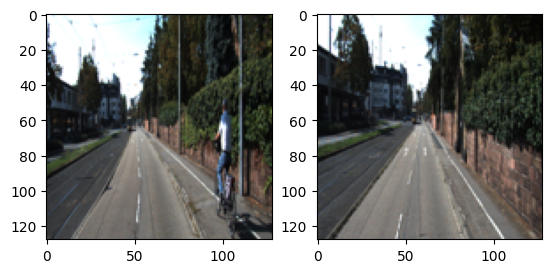

In [8]:
show_images(data,2)

In [9]:
true_mask=loadImages(mask_path,mask=True)

['um_road_000000.png', 'um_road_000001.png', 'um_road_000002.png', 'um_road_000003.png', 'um_road_000004.png', 'um_road_000005.png', 'um_road_000006.png', 'um_road_000007.png', 'um_road_000008.png', 'um_road_000009.png', 'um_road_000010.png', 'um_road_000011.png', 'um_road_000012.png', 'um_road_000013.png', 'um_road_000014.png', 'um_road_000015.png', 'um_road_000016.png', 'um_road_000017.png', 'um_road_000018.png', 'um_road_000019.png', 'um_road_000020.png', 'um_road_000021.png', 'um_road_000022.png', 'um_road_000023.png', 'um_road_000024.png', 'um_road_000025.png', 'um_road_000026.png', 'um_road_000027.png', 'um_road_000028.png', 'um_road_000029.png', 'um_road_000030.png', 'um_road_000031.png', 'um_road_000032.png', 'um_road_000033.png', 'um_road_000034.png', 'um_road_000035.png', 'um_road_000036.png', 'um_road_000037.png', 'um_road_000038.png', 'um_road_000039.png', 'um_road_000040.png', 'um_road_000041.png', 'um_road_000042.png', 'um_road_000043.png', 'um_road_000044.png', 'um_road_

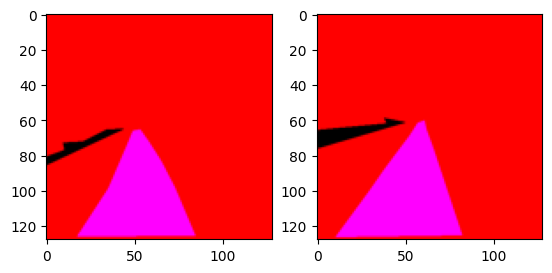

In [10]:
show_images(true_mask,2)

In [11]:
def convert_to_binary_mask(true_mask):
    noMasks=len(true_mask)
    for i in range(noMasks):
        #convert all masks to just binary masks (road and no road)
        road_label =np.array([255, 0, 255])
        cond=np.all(true_mask[i] == road_label, axis = 2)
        true_mask[i]=true_mask[i] * cond[..., np.newaxis]

In [12]:
convert_to_binary_mask(true_mask)

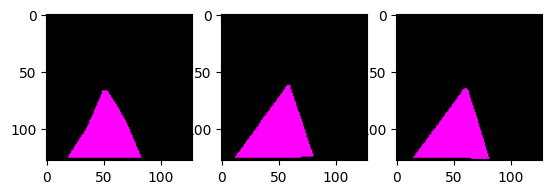

In [13]:
show_images(true_mask,3)

In [14]:
true_mask=np.dot(true_mask[..., :3], [0.2989, 0.5870, 0.1140])
true_mask=np.expand_dims(true_mask, axis=-1)

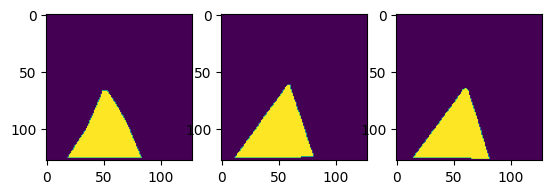

In [15]:
show_images(true_mask,3)

In [16]:
true_mask[true_mask != 0.0]=1.0

In [17]:
data  = data / 255.0

albumentations

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5,border_mode=cv2.BORDER_CONSTANT),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])


In [19]:
data.shape

(289, 128, 128, 3)

In [20]:
true_mask.shape

(289, 128, 128, 1)

In [21]:
data=data.astype(np.float32)
true_mask=true_mask.astype(np.float32)

In [22]:
test_aug=augmentation_pipeline(image=data[5], mask=true_mask[5])
test_example=test_aug["image"]
test_mask=test_aug["mask"]

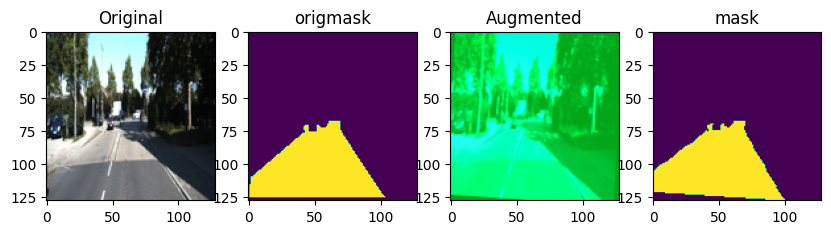

In [23]:
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[5])
ax[0].set_title("Original")

ax[1].imshow(true_mask[5])
ax[1].set_title("origmask")


ax[2].imshow(test_example)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()


In [24]:
NewIMGS=10
for i in range(len(data)):
    for j in range(NewIMGS):
        image = data[i]
        mask = true_mask[i]
        # Apply the augmentation pipeline
        augmented = augmentation_pipeline(image=image, mask=mask)

        image_augmented = augmented["image"]
        mask_augmented = augmented["mask"]
        data = np.vstack((data, image_augmented[np.newaxis,...]))
        true_mask = np.vstack((true_mask, mask_augmented[np.newaxis,...]))

In [25]:
data.shape

(3179, 128, 128, 3)

In [26]:
true_mask.shape

(3179, 128, 128, 1)

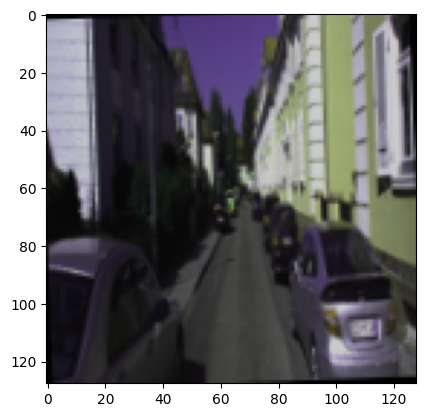

In [29]:
show_images(data[-200:],1)

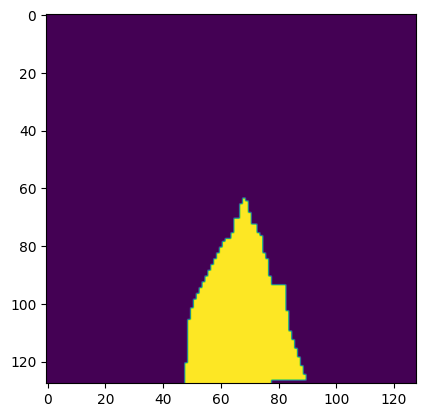

In [30]:
show_images(true_mask[-200:],1)

In [31]:
# Number of training examples
train_set_size = int(len(data) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(data) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = len(data) - train_set_size - validation_set_size
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 2543
Number of Validation Examples: 317
Number of Testing Examples: 319


In [32]:
X_test=data[:test_set_size].transpose((0, 3, 1, 2))
y_test=true_mask[:test_set_size].transpose((0, 3, 1, 2))
print(f'test set size {X_test.shape}')


#rest of the data will be agumented and shuffled for training
data=data[test_set_size:]
true_mask=true_mask[test_set_size:]

# Shuffle the indices
shuffled_indices = np.random.permutation(len(data))

# Use the shuffled indices to shuffle both arrays
shuffled_data = data[shuffled_indices]
shuffled_masks = true_mask[shuffled_indices]


test set size (319, 3, 128, 128)


In [33]:
#train_test_validation split
X_train=shuffled_data[:train_set_size].transpose((0, 3, 1, 2))
y_train=shuffled_masks[:train_set_size].transpose((0, 3, 1, 2))
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
y_val=shuffled_masks[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
print(f'val set size {X_val.shape}')

training set size (2543, 3, 128, 128)
val set size (317, 3, 128, 128)


In [34]:
#create dataset class
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, imgs,mask):
        self.imgs=imgs
        self.mask=mask

    def __len__(self):
        return len(self.imgs)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.imgs[idx]

    def get_batch_masks(self, idx):
    # Fetch a batch of inputs
        return self.mask[idx]


    def __getitem__(self, index):
        imgs=self.get_batch_imgs(index)
        masks=self.get_batch_masks(index)
        return imgs,masks

In [35]:
train_dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

# Create a DataLoader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model U-NET

# U-NET architecture (from scratch)
# ![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [36]:
#since there is alot of double Conv in this architecture it's better to create a class to write less redundant code
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__() # essentail to use nn.Module
        #ex : for the first layer
        #in_channels would be 3 for RGB image
        #out_channels would be 64
        #bias is set to false because we apply batch norm later so it's unnecassary
        self.dconv=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.dconv(x)



class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #this is not deconv this just upsampling
            self.ups.append(DoubleConv(feature*2, feature))



        self.left_over = DoubleConv(features[-1], features[-1]*2) #this represents the last part which starts the UP phase

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #output segmentation  map

    def forward(self,x):
        skip_connections = []

        #starting the down phase will iterate through the downs module
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x)#save this to feed it later
            x=self.pool(x)

        #to move from left to right we pass through the "left_over"

        x=self.left_over(x)
        skip_connections=skip_connections[::-1]
        for idx in range(0,len(self.ups), 2): #our goal it so feed to transposed conv and add skipped connection ups has 2 steps in each so we will make it a step of 2

            sc=skip_connections[idx//2]
            x=self.ups[idx](x) #step 1

            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1) #concatination step
            x = self.ups[idx+1](concat_skip) #step 2


        return torch.sigmoid(self.final_conv(x))#last step in forward


In [37]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.eps = 1e-6

    def forward(self, y_pred, y_true):
        # Flatten the input tensors
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        # Calculate the confusion matrix
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum() - intersection

        # Calculate the IoU and return the complement as the loss
        iou = intersection / (union + self.eps)
        return 1 - iou


In [38]:
import torch.optim as optim

EPOCHS=150
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = IoULoss().to(DEVICE)
# loss_fn =nn.BCELOSS().to(DEVICE)
LEARNING_RATE=1e-3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [39]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []

    for train_input, train_mask in tqdm(data_loader):
        train_mask = train_mask.to(device)
        train_input=train_input.to(device)

        outputs=model(train_input.float())


        loss = loss_fn(outputs.float(), train_mask.float())

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

In [40]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []

    with torch.no_grad():
        for val_input, val_mask in data_loader:

            val_mask = val_mask.to(device)
            val_input=val_input.to(device)
            outputs=model(val_input.float())

            loss = loss_fn(outputs.float(), val_mask.float())
            losses.append(loss.item())

    return np.mean(losses)

In [41]:
from collections import defaultdict
history = defaultdict(list)

In [42]:
loss=math.inf
for epoch in range(EPOCHS):


    train_loss = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)


    val_loss = eval_model(model,val_dataloader,loss_fn, DEVICE)


    if epoch%5 == 0 :
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        print(f'Train loss {train_loss}')
        print(f'Val   loss {val_loss}')
        print()

    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

100%|██████████| 80/80 [00:30<00:00,  2.65it/s]


Epoch 1/150
----------
Train loss 0.5864825859665871
Val   loss 0.48955864310264585



100%|██████████| 80/80 [00:31<00:00,  2.52it/s]


Epoch 6/150
----------
Train loss 0.26769833639264107
Val   loss 0.26832784414291383



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 11/150
----------
Train loss 0.18566967770457268
Val   loss 0.18515958786010742



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 16/150
----------
Train loss 0.13756232634186744
Val   loss 0.15503799319267272



100%|██████████| 80/80 [00:32<00:00,  2.50it/s]


Epoch 21/150
----------
Train loss 0.1081632673740387
Val   loss 0.14381864666938782



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 26/150
----------
Train loss 0.08924637660384178
Val   loss 0.10868491530418396



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 31/150
----------
Train loss 0.08949038535356521
Val   loss 0.1053762137889862



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 36/150
----------
Train loss 0.06657031327486038
Val   loss 0.08267347812652588



100%|██████████| 80/80 [00:32<00:00,  2.50it/s]


Epoch 41/150
----------
Train loss 0.053102954477071765
Val   loss 0.07892663478851318



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 46/150
----------
Train loss 0.042281626164913176
Val   loss 0.06539717316627502



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 51/150
----------
Train loss 0.03563762456178665
Val   loss 0.06394181847572326



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 56/150
----------
Train loss 0.03553445935249329
Val   loss 0.06156107783317566



100%|██████████| 80/80 [00:32<00:00,  2.50it/s]


Epoch 61/150
----------
Train loss 0.038365109264850615
Val   loss 0.06114485263824463



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 66/150
----------
Train loss 0.02594200000166893
Val   loss 0.052605444192886354



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 71/150
----------
Train loss 0.022740840911865234
Val   loss 0.04910635352134705



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 76/150
----------
Train loss 0.02136092483997345
Val   loss 0.049265050888061525



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 81/150
----------
Train loss 0.01947815716266632
Val   loss 0.04703754186630249



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 86/150
----------
Train loss 0.019239597767591477
Val   loss 0.05147237777709961



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 91/150
----------
Train loss 0.024543328583240508
Val   loss 0.046420007944107056



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 96/150
----------
Train loss 0.016396989673376085
Val   loss 0.0447503924369812



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 101/150
----------
Train loss 0.015072346478700639
Val   loss 0.04247097373008728



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 106/150
----------
Train loss 0.015299859642982482
Val   loss 0.044036072492599485



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 111/150
----------
Train loss 0.01426902785897255
Val   loss 0.04255342483520508



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 116/150
----------
Train loss 0.014025797694921493
Val   loss 0.043287014961242674



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 121/150
----------
Train loss 0.013819033652544022
Val   loss 0.04254046082496643



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 126/150
----------
Train loss 0.012858259677886962
Val   loss 0.04212890267372131



100%|██████████| 80/80 [00:32<00:00,  2.50it/s]


Epoch 131/150
----------
Train loss 0.012415163964033128
Val   loss 0.041979140043258666



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 136/150
----------
Train loss 0.012276969850063324
Val   loss 0.03968989849090576



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 141/150
----------
Train loss 0.047158849984407426
Val   loss 0.057771599292755126



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Epoch 146/150
----------
Train loss 0.011342275887727737
Val   loss 0.039449411630630496



100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


In [43]:
from google.colab import files
os.listdir('/content')

model.load_state_dict(torch.load('/content/best_model_state.bin'))

<All keys matched successfully>

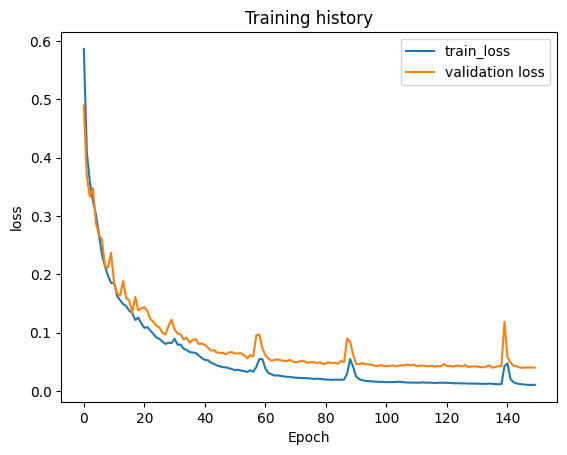

In [44]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()


In [45]:
prediction=model(torch.tensor(X_test[56][np.newaxis,...],device=DEVICE)).cpu().detach().numpy()

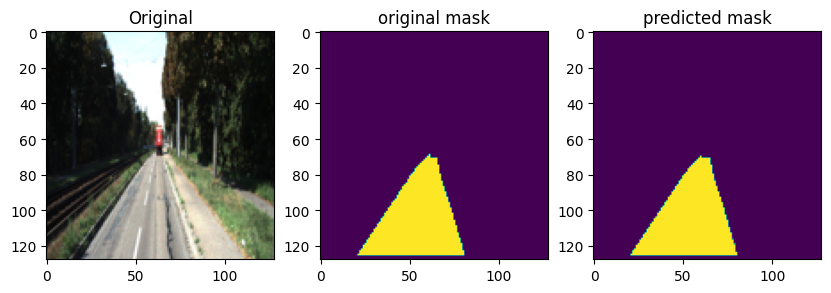

In [46]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[56].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[56].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(prediction[0].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


In [47]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:

            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())

            masks.append(outputs.cpu().detach().numpy())

            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [48]:
loss,masks=get_predicted_masks(model,test_dataloader,loss_fn,DEVICE)

In [49]:
loss

0.017296719551086425

In [50]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

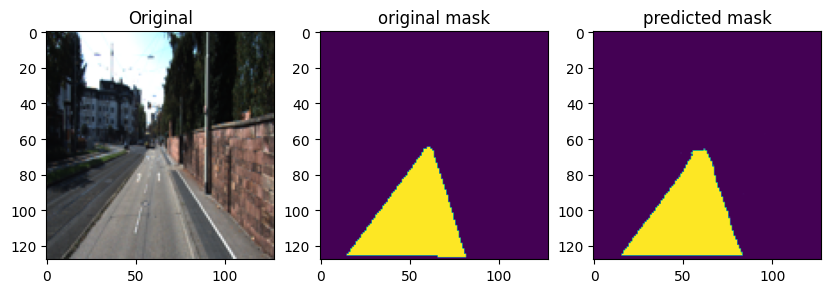

In [51]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[2].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[2].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[2].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


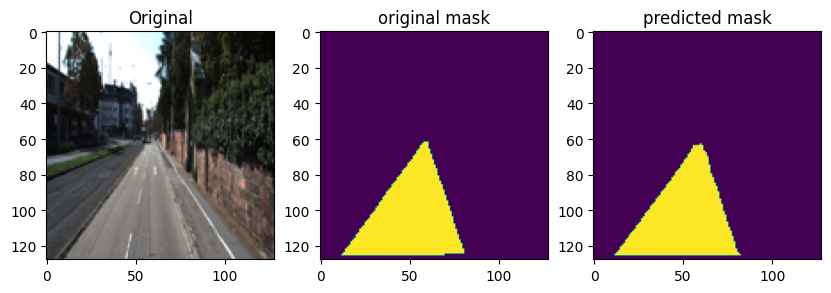

In [52]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[1].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[1].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[1].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


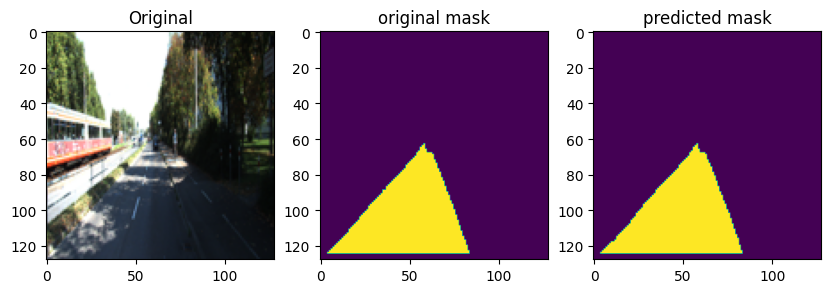

In [53]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[14].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[14].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[14].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


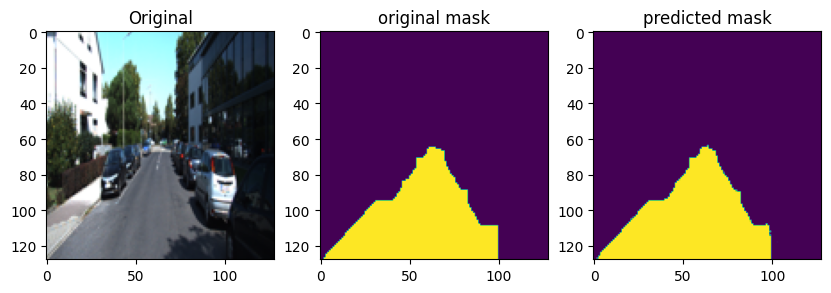

In [54]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[200].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[200].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[200].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


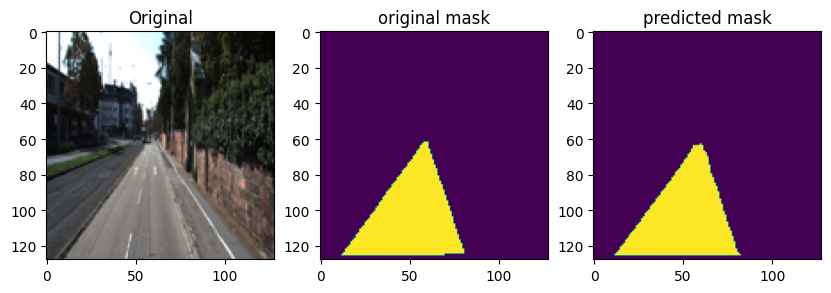

In [58]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[300].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[300].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[300].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


In [74]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload images from your local machine


Saving frame34.jpg to frame34.jpg


In [75]:
import torch
import numpy as np
from PIL import Image

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))  # Resize to the same size as training images
    image = np.array(image) / 255.0  # Normalize pixel values to (0, 1)
    image = image.astype(np.float32)
    image = np.transpose(image, (2, 0, 1))  # Change from HWC to CHW format
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    return image

# Preprocess uploaded images
custom_images = []
for image_name in uploaded.keys():
    image = preprocess_image(image_name)
    custom_images.append(image)

custom_images = torch.cat(custom_images)
print(f'Custom images shape: {custom_images.shape}')  # Should be (N, C, H, W)


Custom images shape: torch.Size([1, 3, 128, 128])


In [76]:
# Load the trained model
model = UNET(in_channels=3, out_channels=1)
model.load_state_dict(torch.load('/content/best_model_state.bin', map_location=torch.device('cpu')))
model.eval()


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

Input tensor shape: torch.Size([1, 3, 128, 128])
Output tensor shape: torch.Size([1, 1, 128, 128])


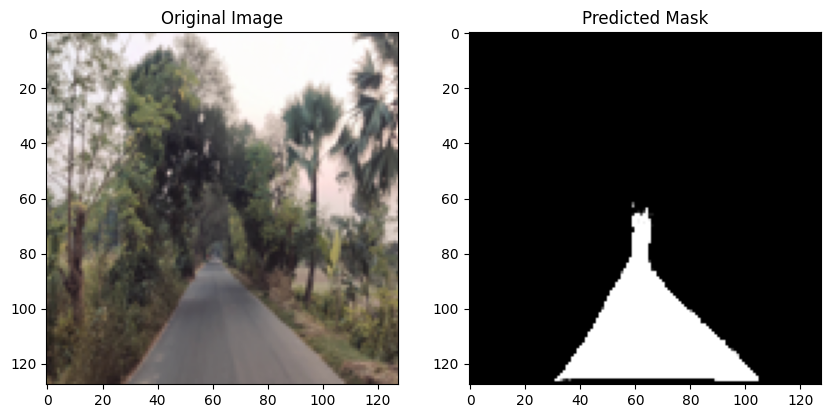

In [77]:
import matplotlib.pyplot as plt

def predict_image(image_tensor):
    # Ensure the input tensor has the correct shape
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        print(f'Input tensor shape: {image_tensor.shape}')  # Should be (1, C, H, W)
        image_tensor = image_tensor.to(torch.device('cpu'))  # Ensure the tensor is on CPU
        output = model(image_tensor.float())
        print(f'Output tensor shape: {output.shape}')  # Should be (1, 1, H, W)
        return output.cpu().detach().numpy()

# Predict masks for the uploaded images
predicted_masks = []
for image in custom_images:
    predicted_mask = predict_image(image)
    predicted_masks.append(predicted_mask)

# Visualize the results
for i, image_tensor in enumerate(custom_images):
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
    mask_np = predicted_masks[i].squeeze(0).transpose(1, 2, 0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")

    ax[1].imshow(mask_np, cmap='gray')
    ax[1].set_title("Predicted Mask")

    plt.show()
